# MR3 - Majority voting and unsupervised LDA

In [7]:
import re
import numpy as np
import pandas as pd
import pandas_profiling
from pprint import pprint

import os
import glob


from itertools import chain

#NLTK
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pickle

import spacy # can be e.g. used for lemmatization

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Plotting
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## All projects from H2020 and FP7

In [8]:
h2020 = pd.read_csv("datasets/data_may20/h2020_clean/h2020_full.csv")
fp7 = pd.read_csv("datasets/data_may20/fp7_clean/fp7_full.csv")

In [9]:
projects_all = pd.concat([fp7, h2020], ignore_index = True)
projects_all.shape

(55030, 31)

In [10]:
h2020_ids = list(h2020.id)
len(h2020_ids)

29314

In [11]:
fp7_ids = list(fp7.id)
len(fp7_ids)

25716

### Hyperparameter list

In [12]:
n_clouds_list = [10] #[3, 6, 10]
mob_projects_max_list = [500, 1000, 5000]

initial_seed_list = [
    [['mobility', 'transport', "airport", "airline", "aircraft", "passenger"]],
    [['mobility', 'transport', "airport", "airline", "aircraft", "passenger", "aviation", "travel", "flight"]],
    [['mobility', 'transport', "airport", "airline", "aircraft", "passenger", "aviation", "travel", "flight",\
      "intermodality", "comodality", "crossmodal"]]
    ]

tf_idf_list = [False, True]

# Majority voting

### Selected "voters"

In [13]:
# Should we use the v3 approach in voting as well?
use_v3 = False

In [14]:
version = "v2_0"
#version = "v2_1"

In [15]:
# Each voter is a tuple of (max_projects, seed_list, tf_idf)

if version == "v2_0":
    voters = [
        ("500", initial_seed_list[2], "False"),
        ("1000", initial_seed_list[0], "False"),
        ("5000", initial_seed_list[1], "False"),
        ("5000", initial_seed_list[2], "False"),
        ("5000", initial_seed_list[0], "True"),
        ("1000", initial_seed_list[0], "True"),
        ("500", initial_seed_list[1], "True")
    ]
    
if version == "v2_1":
    voters = [
        ("1000", initial_seed_list[0], "False"), # small, 274 projects, tie breaker
        ("2000", initial_seed_list[0], "False"), # medium, around 1000 projects
        ("2000", initial_seed_list[1], "False"),
        ("2000", initial_seed_list[2], "False"),
        ("5000", initial_seed_list[0], "False"), # large, from 3000 projects
        ("5000", initial_seed_list[2], "False"),
        ("5000", initial_seed_list[1], "True"),
        ("750", initial_seed_list[0], "True"), # extra number 1
        ("2000", initial_seed_list[2], "True") #extra number 2
        
    ]

if use_v3:
    voters_v3 = [
        ("1000", initial_seed_list[1], "True"),
        ("5000", initial_seed_list[0], "True"),
    ]

In [16]:
files = []

for v in voters:
    files.append("..nlp_camera_mr3/datasets/data_oct19/mr2_results/lda_outputs/" + v[0] + "projectsMax_10clouds_seedList" + \
                 str(v[1]) + "tfIdf" + v[2] + "_" + version + ".csv")
if use_v3:
    for v in voters_v3:
        files.append("..nlp_camera_mr3/datasets/data_oct19/mr2_results/lda_outputs/" + v[0] + "projectsMax_10clouds_seedList" + \
                     str(v[1]) + "tfIdf" + v[2] + "_" + version + ".csv")
    
print("We have ", len(files), " voters.")

We have  7  voters.


In [17]:
"""dfs = []

for f in files:
    x = pd.read_csv(f)
    if use_v3:
        y = x[['id', 'acronym', 'title', 'objective', 'summary', 'workPerformed', 'finalResults', 'text', 'score']]
    else:
        y = x[['id', 'acronym', 'title', 'objective', 'summary', 'workPerformed', 'finalResults', 'text', 'clean_text', 'score']]
    dfs.append(y)
    """

"dfs = []\n\nfor f in files:\n    x = pd.read_csv(f)\n    if use_v3:\n        y = x[['id', 'acronym', 'title', 'objective', 'summary', 'workPerformed', 'finalResults', 'text', 'score']]\n    else:\n        y = x[['id', 'acronym', 'title', 'objective', 'summary', 'workPerformed', 'finalResults', 'text', 'clean_text', 'score']]\n    dfs.append(y)\n    "

In [18]:
#type(dfs[0].clean_text[0])

In [19]:
#print(len(dfs))
#dfs[0].head()

In [20]:
#len(dfs[0].id.unique())

## Merge all selected projects into a single dataframe and create a list of candidate IDs

In [21]:
# OLD
#projects_all = pd.concat(dfs, axis=0)

## Read the mobility selected projects

In [22]:
df_X = pd.read_csv("datasets/data_may20/outputs/mobility_projects_clean_text.csv")
df_X.shape

(926, 14)

In [23]:
df_X.head(2)

,Unnamed: 0,id,acronym,title,objective,summary,workPerformed,finalResults,text,sentences,tokens,pos_tokens,lemmas,clean_text
0,0,120009,SE2A,"Nanoelectronics for Safe, Fuel Efficient and E...",The societal need for a transport infrastructu...,NaN,NaN,NaN,"Nanoelectronics for Safe, Fuel Efficient and E...","['Nanoelectronics for Safe, Fuel Efficient and...","['nanoelectronics', 'safe', 'fuel', 'efficient...","[[('Nanoelectronics', 'NNS'), ('for', 'IN'), (...","[['Nanoelectronics', 'for', 'Safe', ',', 'Fuel...",nanoelectronics safe fuel efficient environmen...
1,1,204513,DCBIF,Flight dynamics and control of birds and insects,"Insects bristle with sensors, but how do they ...",This project aimed to develop an understanding...,NaN,NaN,Flight dynamics and control of birds and insec...,['Flight dynamics and control of birds and ins...,"['flight', 'dynamic', 'control', 'bird', 'inse...","[[('Flight', 'NNP'), ('dynamics', 'NNS'), ('an...","[['Flight', 'dynamic', 'and', 'control', 'of',...",flight dynamic control bird insect insects bri...


In [25]:
df_final_selection = df_X[['id', 'acronym', 'title', 'objective', 'summary', 'workPerformed', 'finalResults', 'text', 'clean_text']]

In [26]:
df_final_selection.shape

(926, 9)

In [21]:
#project_ids = list(projects_all.id.unique())

In [22]:
#len(project_ids) # number of unique projects that enter the voting process

4096

In [28]:
# list of PROJECT IDs of each voter (LDA output)
#votes = [list(df.id.unique()) for df in dfs]
#len(votes)

In [31]:
# majority voting function

"""
from collections import OrderedDict

def project_selection_voting(votes, candidates):
    #votes - list of lists of project IDs for which that voters votes
    #candidates - a list of all the projects that at least one voter has selected

    
    results = OrderedDict.fromkeys(candidates)
    
    for c in candidates:
        results[c] = np.sum([c in y for y in votes])
    
    return results
    
"""

'\nfrom collections import OrderedDict\n\ndef project_selection_voting(votes, candidates):\n    #votes - list of lists of project IDs for which that voters votes\n    #candidates - a list of all the projects that at least one voter has selected\n\n    \n    results = OrderedDict.fromkeys(candidates)\n    \n    for c in candidates:\n        results[c] = np.sum([c in y for y in votes])\n    \n    return results\n    \n'

In [33]:
#results = project_selection_voting(votes, project_ids)

In [34]:
#len(results)

In [35]:
#import math

In [36]:
# filter out those projects that won the majority vote, i.e. that have at least ceiling(n_voters/2) votes

"""
n_voters = len(votes)
print("There are ", n_voters, " voters.")
min_votes_needed = math.ceil(n_voters/2.0)
print("Minimal votes needed for a project to be selected is ", min_votes_needed)

final_project_selection = [k for k,v in results.items() if v >= min_votes_needed]
len(final_project_selection)
"""

'\nn_voters = len(votes)\nprint("There are ", n_voters, " voters.")\nmin_votes_needed = math.ceil(n_voters/2.0)\nprint("Minimal votes needed for a project to be selected is ", min_votes_needed)\n\nfinal_project_selection = [k for k,v in results.items() if v >= min_votes_needed]\nlen(final_project_selection)\n'

In [37]:
# reset index in projects_all

#projects_all.reset_index(inplace=True)
#projects_all.shape

In [30]:
#projects_all.clean_text[0]

In [38]:
"""
t = projects_all.drop_duplicates(subset="id")
print(t.shape)
df_final_selection = t[t.id.isin(final_project_selection)]

df_final_selection.shape
"""

'\nt = projects_all.drop_duplicates(subset="id")\nprint(t.shape)\ndf_final_selection = t[t.id.isin(final_project_selection)]\n\ndf_final_selection.shape\n'

In [40]:
df_final_selection.head(2)

,id,acronym,title,objective,summary,workPerformed,finalResults,text,clean_text
0,120009,SE2A,"Nanoelectronics for Safe, Fuel Efficient and E...",The societal need for a transport infrastructu...,NaN,NaN,NaN,"Nanoelectronics for Safe, Fuel Efficient and E...",nanoelectronics safe fuel efficient environmen...
1,204513,DCBIF,Flight dynamics and control of birds and insects,"Insects bristle with sensors, but how do they ...",This project aimed to develop an understanding...,NaN,NaN,Flight dynamics and control of birds and insec...,flight dynamic control bird insect insects bri...


In [41]:
#df_final_selection.sort_values(by="score", ascending=False).head()

In [42]:
#df_final_selection.sort_values(by="score", ascending=False).tail()

# Validation: expert labelled projects

In [44]:
labelled = pd.read_csv("datasets/data_may20/auxiliar/labelled_projects.csv")

labelled_pos = labelled[labelled['mobility_relevance'] == 1]
pos_ids = list(labelled_pos.id)

# negatively labelled
labelled_neg = labelled[labelled['mobility_relevance'] == 0]
neg_ids = list(labelled_neg.id)

In [46]:
final_project_selection = list(df_final_selection.id)

In [47]:
selected_projects = [x in final_project_selection for x in pos_ids]
print("LDA selected ", sum(selected_projects), " projects labelled positively by experts.")
print("That yields a precision of ", sum(selected_projects) / len(pos_ids) * 100, " %.")

non_selected_projects = [x in final_project_selection for x in neg_ids]
print("LDA selected ", sum(non_selected_projects), " projects labelled negatively by experts.")
print("That yields a recall of ", (len(neg_ids) - sum(non_selected_projects)) / len(neg_ids) * 100, " %.")

excluded_projects = [x for x in pos_ids if x not in final_project_selection]
print("Projects that were not selected include: ", excluded_projects)
print(labelled[labelled.id.isin(excluded_projects)])

LDA selected  45  projects labelled positively by experts.
That yields a precision of  91.83673469387756  %.
LDA selected  3  projects labelled negatively by experts.
That yields a recall of  70.0  %.
Projects that were not selected include:  [252489, 287106, 653289, 723989]
        id               acronym  mobility_relevance  expert programme
11  252489  PUBLIC PUT IN MOTION                   1       0       FP7
18  287106                 ELMOs                   1       0       FP7
37  653289                DARWIN                   1       1     H2020
47  723989              SKILLFUL                   1       0     H2020


## Label selected projects with their framework: H2020, FP7

In [48]:
def decide_framework(x):
    # x is project ID
    if x in fp7_ids:
        return "FP7"
    else:
        return "H2020"

In [49]:
# test
print("Project id is ", df_final_selection.id.values[3])
print(decide_framework(df_final_selection.id.values[3]))

Project id is  206929
FP7


In [50]:
df_final_selection["framework"] = df_final_selection.id.apply(decide_framework)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
df_final_selection.tail(2)

,id,acronym,title,objective,summary,workPerformed,finalResults,text,clean_text,framework
924,877528,Zeleros Hyperloop,LEVITATION AND PROPULSION SUBSYSTEMS FOR SUSTA...,"Over the years, transport of people and goods ...",NaN,NaN,NaN,LEVITATION AND PROPULSION SUBSYSTEMS FOR SUSTA...,levitation propulsion subsystems sustainable m...,H2020
925,878052,MAAS,MOBILITY AS A SERVICE PLATFORM for employers a...,UN predicts that more than 68% of the world’s ...,"Problems regarding urban transportation, such ...",Technical feasibility – we have developed a r...,We have achieved a thorough analysis of the ta...,MOBILITY AS A SERVICE PLATFORM for employers a...,mobility service platform employer individual ...,H2020


In [52]:
count_h2020_selected = np.sum(df_final_selection["framework"] == "H2020")
count_fp7_selected = np.sum(df_final_selection["framework"] == "FP7")

print("Out of ", df_final_selection.shape[0], " projects selected", count_h2020_selected, " are from H2020, and ", \
     count_fp7_selected, " are from FP7.")

Out of  926  projects selected 519  are from H2020, and  407  are from FP7.


In [53]:
# Save to CSV

dirName = "mr3_results"

try:
    os.makedirs(dirName)    
    print("Directory " , dirName ,  " Created ")
except FileExistsError:
    print("Directory " , dirName ,  " already exists")
    
df_final_selection.to_csv("mr3_results/final_project_selection_mr3" + version + ".csv")

Directory  mr3_results  Created 


#### Project list for the Annex in MR3

In [54]:
# add data from the original source: financial contribution, framework programme, coordinator data
projects_all.columns.values

array(['rcn', 'id', 'acronym', 'status', 'programme', 'topics',
       'frameworkProgramme', 'title', 'startDate', 'endDate',
       'projectUrl', 'objective', 'totalCost', 'ecMaxContribution',
       'call', 'fundingScheme', 'coordinator', 'coordinatorCountry',
       'participants', 'participantCountries', 'subjects', 'summary',
       'lastUpdateDate', 'rcn_report', 'title_report', 'projectAcronym',
       'workPerformed', 'finalResults', 'projectID', 'relatedFile', 'url'],
      dtype=object)

In [55]:
df_temp = df_final_selection[["id", "acronym", "title"]].merge(projects_all[['id', 'coordinator', 'coordinatorCountry', 'totalCost', 'frameworkProgramme', 'startDate', 'endDate']], \
                                                               how='left', on='id')
df_temp.shape

(926, 9)

In [56]:
df_temp.head()

,id,acronym,title,coordinator,coordinatorCountry,totalCost,frameworkProgramme,startDate,endDate
0,120009,SE2A,"Nanoelectronics for Safe, Fuel Efficient and E...",TEXNOLOGIES FOTONIKON KAI HLEKTRONIKON SYSTHMA...,EL,21656394,FP7,2009-01-01,2011-12-01
1,204513,DCBIF,Flight dynamics and control of birds and insects,"THE CHANCELLOR, MASTERS AND SCHOLARS OF THE UN...",UK,1954565,FP7,2008-06-01,2014-05-31
2,205768,AGAPE,ACARE Goals Progress Evaluation,AEROSPACE AND DEFENCE INDUSTRIES ASSOCIATION O...,BE,1031474,FP7,2008-07-01,2010-06-30
3,206929,SERVICE,Strengthening Railway Vehicles Center of Facul...,FAKULTET ZA MASINSTVO I GRADJEVINARSTVO U KRAL...,RS,"1166313,81",FP7,2008-05-01,2011-04-30
4,211012,CSSA,Clean Sky Support Action,AIRBUS,FR,1999985,FP7,2007-05-04,2008-05-03


In [57]:
df_temp.to_csv("mr3_results/mr3_final_project_list_for_annex.csv")

# LDA

# Run LDA on the selected projects to get features for filter 2

In [58]:
df_final_selection.shape

(926, 10)

In [59]:
df_final_selection.clean_text[0]

"""
IMPORTANT:

Column "clean_text" is to be used in LDA.

"""

'\nIMPORTANT:\n\nColumn "clean_text" is to be used in LDA.\n\n'

### Prepare

In [60]:
df_final_selection['clean_text'] = df_final_selection['clean_text'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
type(df_final_selection.clean_text[0])

str

In [62]:
# create tokens from the clean text
df_final_selection['tokens'] = df_final_selection['clean_text'].apply(word_tokenize)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
df_final_selection['tokens'][0][:4]

['nanoelectronics', 'safe', 'fuel', 'efficient']

In [64]:
tokens = df_final_selection['tokens'].tolist()
dictionary_lda = corpora.Dictionary(tokens) # dictionary: mapping between terms and their integer IDs - id2word

In [65]:
type(dictionary_lda)

gensim.corpora.dictionary.Dictionary

In [66]:
# create corpus - BoW format = list of (token_id, token_count) tuples
corpus = [dictionary_lda.doc2bow(tok) for tok in tokens]

In [67]:
type(corpus)

list

In [68]:
len(corpus)

926

In [69]:
corpus[0][:5]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [70]:
# what word is hiding behind id 2?
dictionary_lda[2]

'achieve'

In [71]:
# Human-readable format of corpus (term-frequency)
[ [(dictionary_lda[id], freq) for id, freq in cp] for cp in corpus[:1]][0][:5]

[('academic', 1),
 ('accident', 1),
 ('achieve', 1),
 ('agenda', 1),
 ('ambition', 1)]

###  Define LDA model

API: https://radimrehurek.com/gensim/models/ldamodel.html

In [72]:
n_topics = 10 # number of clouds/topics
alpha = 'auto' #[0.01]*n_topics # LDA hyperparameter, affects sparsity of topics
eta = [0.01]*len(dictionary_lda.keys()) # LDA hyperparameter, affects sparsity of topics

In [73]:
lda_model = gensim.models.LdaModel(corpus,
                            num_topics = n_topics,
                            id2word = dictionary_lda,
                            passes = 10, # total number of training passes
                            chunksize = 100, #the number of documents to be used in each training chunk
                            update_every=1, # how often the model parameters are updated
                            random_state = 10,
                            alpha = alpha,
                            eta = eta,
                            per_word_topics = True
                           )

# Explore LDA results

In [74]:
# LIST TOPICS

for i, topic in lda_model.show_topics(formatted=True, num_topics=n_topics, num_words = 20):
    print(str(i)+": "+ topic)
    print()

0: 0.036*"railway" + 0.031*"safety" + 0.028*"road" + 0.023*"rail" + 0.022*"infrastructure" + 0.017*"system" + 0.015*"maintenance" + 0.011*"risk" + 0.010*"track" + 0.010*"train" + 0.009*"accident" + 0.009*"human" + 0.009*"design" + 0.008*"training" + 0.008*"asset" + 0.006*"monitoring" + 0.006*"identify" + 0.006*"network" + 0.006*"improve" + 0.005*"assessment"

1: 0.034*"model" + 0.032*"data" + 0.023*"traffic" + 0.017*"emission" + 0.017*"atm" + 0.012*"air" + 0.011*"environmental" + 0.010*"performance" + 0.009*"cost" + 0.009*"weather" + 0.009*"assessment" + 0.008*"reduction" + 0.008*"trajectory" + 0.008*"effect" + 0.007*"forecast" + 0.007*"methodology" + 0.007*"measure" + 0.007*"modelling" + 0.007*"climate" + 0.007*"management"

2: 0.029*"flight" + 0.019*"aircraft" + 0.013*"system" + 0.012*"operation" + 0.012*"pilot" + 0.010*"concept" + 0.010*"safety" + 0.008*"airspace" + 0.007*"air" + 0.007*"aviation" + 0.007*"trajectory" + 0.007*"airport" + 0.006*"crew" + 0.006*"sesar" + 0.006*"procedur

# Compute model perplexity and coherence score

Perplexity and topic coherence (https://rare-technologies.com/what-is-topic-coherence/) are measures of judging how good a topic model is.

In [75]:
# perplexity: https://towardsdatascience.com/perplexity-intuition-and-derivation-105dd481c8f3

# It depends on the created corpus - preprocessing!

print("Perplexity: ", lda_model.log_perplexity(corpus)) # lower perplexity is better

Perplexity:  -14.32972534031431


In [76]:
# Topic coherence

coherence_model_lda = CoherenceModel(lda_model, texts=tokens, dictionary=dictionary_lda, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print("Topic coherence score: ", coherence_lda)

Topic coherence score:  0.44892130885913717


# Visualise the topic-keywords

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

If you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

In [77]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_lda, R = 20)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

# LDA Mallet version

Mallet's version in general gives a better quality of topics.

Gensim provides a wrapper to implement it. Download from here: https://www.machinelearningplus.com/wp-content/uploads/2018/03/mallet-2.0.8.zip

In [80]:
#/Users/damir/Desktop/[INX] CAMERA/NLP/notebooks/nlp_camera_mr2

#mallet_path = '/Users/damir/Desktop/mallet-2.0.8/bin/mallet' #UPDATE!
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary_lda)

In [81]:
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

In [82]:
# Topic coherence: Mallet model

#coherence_model_mallet = CoherenceModel(ldamallet, texts=tokens, dictionary=dictionary_lda, coherence='c_v')
#coherence_ldamallet = coherence_model_mallet.get_coherence()

#print("Topic coherence score: ", coherence_ldamallet)

 ### Mallet model improved the coherence score a bit, but not significantly. I think the problem still might be too many topics.

# Finding optimal number of topics

Build a number of LDA models with different values of n_topics. Choose the one with the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

In [83]:
# Train multiple LDA models and calculate their coherence scores

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2, mallet=False):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    mallet: if True, use Mallet model instead of LdaModel

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for n_topics in range(start, limit, step):
        if mallet:
            model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n_topics, id2word=dictionary)
        else:
            model = gensim.models.LdaModel(corpus,
                            num_topics = n_topics,
                            id2word = dictionary,
                            passes = 10, # total number of training passes
                            chunksize = 100, #the number of documents to be used in each training chunk
                            update_every=1, # how often the model parameters are updated
                            random_state = 10,
                            alpha = alpha,
                            eta = eta,
                            per_word_topics = True
                           )
            
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [115]:
# RUNS OPTIMISATION!!

model_list, coherence_values = compute_coherence_values(dictionary=dictionary_lda, corpus=corpus, texts=tokens, \
                                                        start=2, limit=50, step=1, mallet=False)

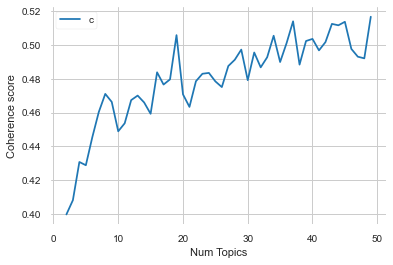

In [116]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best'); plt.grid()
plt.show()

In [117]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3996
Num Topics = 3  has Coherence Value of 0.4081
Num Topics = 4  has Coherence Value of 0.4307
Num Topics = 5  has Coherence Value of 0.4288
Num Topics = 6  has Coherence Value of 0.4454
Num Topics = 7  has Coherence Value of 0.4604
Num Topics = 8  has Coherence Value of 0.4711
Num Topics = 9  has Coherence Value of 0.4663
Num Topics = 10  has Coherence Value of 0.4489
Num Topics = 11  has Coherence Value of 0.4537
Num Topics = 12  has Coherence Value of 0.4674
Num Topics = 13  has Coherence Value of 0.4701
Num Topics = 14  has Coherence Value of 0.466
Num Topics = 15  has Coherence Value of 0.4593
Num Topics = 16  has Coherence Value of 0.4839
Num Topics = 17  has Coherence Value of 0.4767
Num Topics = 18  has Coherence Value of 0.4797
Num Topics = 19  has Coherence Value of 0.506
Num Topics = 20  has Coherence Value of 0.4708
Num Topics = 21  has Coherence Value of 0.4634
Num Topics = 22  has Coherence Value of 0.4786
Num Topics = 23  has Co

In [88]:
# SELECT OPTIMAL MODEL
# values to try: 9, 18, 31, 49?
num_top_opt = 8 # optimal number of topics
#num_top_opt = 10
#num_top_opt = 23
#num_top_opt = 18
#num_top_opt = 31

optimal_model = model_list[num_top_opt - 2]

In [89]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.026*"market" + 0.023*"vehicle" + 0.019*"system" + 0.014*"cost" + '
  '0.011*"technology" + 0.011*"electric" + 0.011*"solution" + 0.009*"company" '
  '+ 0.009*"energy" + 0.009*"customer" + 0.008*"business" + 0.008*"product" + '
  '0.008*"feasibility" + 0.007*"high" + 0.007*"passenger"'),
 (1,
  '0.043*"rail" + 0.042*"railway" + 0.024*"infrastructure" + '
  '0.018*"maintenance" + 0.012*"freight" + 0.011*"road" + 0.011*"transport" + '
  '0.011*"train" + 0.011*"track" + 0.010*"network" + 0.010*"asset" + '
  '0.009*"system" + 0.008*"cost" + 0.007*"measure" + 0.006*"risk"'),
 (2,
  '0.024*"flight" + 0.018*"airport" + 0.015*"aircraft" + 0.012*"system" + '
  '0.011*"operation" + 0.011*"concept" + 0.010*"atm" + 0.009*"safety" + '
  '0.009*"pilot" + 0.009*"air" + 0.009*"traffic" + 0.008*"trajectory" + '
  '0.007*"operational" + 0.007*"aviation" + 0.006*"airspace"'),
 (3,
  '0.043*"road" + 0.031*"traffic" + 0.024*"safety" + 0.024*"vehicle" + '
  '0.013*"driver" + 0.011*"car" + 0.009*"us

# Visualise the optimal model topics

In [90]:
# Is the optimal model Mallet?

use_mallet = False

In [91]:
# need to convert Mallet model to LdaModel for vis purposes in pyLDAvis

if use_mallet:
    optimal_lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
else:
    optimal_lda_model = optimal_model

In [92]:
vis = pyLDAvis.gensim.prepare(topic_model=optimal_lda_model, corpus=corpus, dictionary=dictionary_lda, R = 20, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Comment:

For some reason, when setting number of topics to 23 the visualisation method returns the following error:

Object of type 'complex' is not JSON serializable

This didn't occur with any other number of topics so far. It seems the issue is that, for some reason, there is a complex number in the LDA matrix. Not sure why and how that happened. See more: https://github.com/bmabey/pyLDAvis/issues/69

In [93]:
# export as a standalone html

pyLDAvis.save_html(vis, 'mr3_results/lda_ntopic' + str(num_top_opt) + '.html')

# Topic distribution for each document as its features!

In [94]:
optimal_lda_model.get_document_topics(corpus[0], minimum_probability=0) # to get all the probabilities, set minimum_probability = 0

[(0, 0.18901707),
 (1, 0.00045021783),
 (2, 0.0013870125),
 (3, 0.06855672),
 (4, 0.27031714),
 (5, 0.17409787),
 (6, 0.29315948),
 (7, 0.0030144854)]

In [95]:
full_topic_distribution = np.zeros((len(corpus), optimal_lda_model.num_topics))

full_topic_distribution.shape

(926, 8)

In [96]:
for i in range(full_topic_distribution.shape[0]):
    row = optimal_lda_model.get_document_topics(corpus[i], minimum_probability=0)
    probs = [x[1] for x in row]
    
    full_topic_distribution[i, :] = probs

In [97]:
full_topic_distribution

array([[1.89019591e-01, 4.50217776e-04, 1.38701242e-03, ...,
        1.74094826e-01, 2.93160588e-01, 3.01449327e-03],
       [2.19498217e-01, 1.30233646e-04, 1.14234999e-01, ...,
        1.20905235e-01, 8.12376617e-04, 8.14310159e-04],
       [1.86313316e-03, 3.65142449e-04, 1.12358935e-03, ...,
        3.06411892e-01, 6.34706497e-01, 2.37280643e-03],
       ...,
       [6.27504766e-01, 1.86420177e-04, 1.05667077e-01, ...,
        6.03948385e-02, 1.11872610e-03, 5.64311147e-02],
       [6.08189285e-01, 4.26606915e-04, 1.30966096e-03, ...,
        1.46204429e-02, 3.23833572e-03, 2.87025928e-01],
       [3.41662429e-02, 4.20280173e-02, 4.94510576e-04, ...,
        4.11649235e-02, 9.62665537e-04, 8.74335945e-01]])

In [98]:
np.sum(np.isnan(full_topic_distribution))  #  NO NaNs

0

In [102]:
# add topic distribution as features
cols = ["t" + str(x) for x in range(optimal_lda_model.num_topics)]
df_final_selection[cols] = pd.DataFrame(full_topic_distribution)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [103]:
df_final_selection.head(3)

,id,acronym,title,objective,summary,workPerformed,finalResults,text,clean_text,framework,tokens,t0,t1,t2,t3,t4,t5,t6,t7
0,120009,SE2A,"Nanoelectronics for Safe, Fuel Efficient and E...",The societal need for a transport infrastructu...,NaN,NaN,NaN,"Nanoelectronics for Safe, Fuel Efficient and E...",nanoelectronics safe fuel efficient environmen...,FP7,"[nanoelectronics, safe, fuel, efficient, envir...",0.189020,0.000450,0.001387,0.068556,0.270317,0.174095,0.293161,0.003014
1,204513,DCBIF,Flight dynamics and control of birds and insects,"Insects bristle with sensors, but how do they ...",This project aimed to develop an understanding...,NaN,NaN,Flight dynamics and control of birds and insec...,flight dynamic control bird insect insects bri...,FP7,"[flight, dynamic, control, bird, insect, insec...",0.219498,0.000130,0.114235,0.108499,0.435106,0.120905,0.000812,0.000814
2,205768,AGAPE,ACARE Goals Progress Evaluation,ACARE (the Advisory Council for Aeronautics Re...,NaN,NaN,NaN,ACARE Goals Progress Evaluation ACARE (the Adv...,acare goals progress evaluation acare advisory...,FP7,"[acare, goals, progress, evaluation, acare, ad...",0.001863,0.000365,0.001124,0.000800,0.052357,0.306412,0.634706,0.002373


In [104]:
df_final_selection.tail(3)

,id,acronym,title,objective,summary,workPerformed,finalResults,text,clean_text,framework,tokens,t0,t1,t2,t3,t4,t5,t6,t7
923,877007,CAARESYS,CAARESYS: vehicle passenger monitoring system ...,CAARESYS is a privately held company founded i...,In cabin Safety - Aautomotive industry and car...,"In the beginning of the process, our team star...",Due to the excellence BabyCaare system perform...,CAARESYS: vehicle passenger monitoring system ...,caaresys vehicle passenger monitor system base...,H2020,"[caaresys, vehicle, passenger, monitor, system...",0.627505,0.000186,0.105667,0.148171,0.000526,0.060395,0.001119,0.056431
924,877528,Zeleros Hyperloop,LEVITATION AND PROPULSION SUBSYSTEMS FOR SUSTA...,"Over the years, transport of people and goods ...",NaN,NaN,NaN,LEVITATION AND PROPULSION SUBSYSTEMS FOR SUSTA...,levitation propulsion subsystems sustainable m...,H2020,"[levitation, propulsion, subsystems, sustainab...",0.608189,0.000427,0.001310,0.000936,0.084254,0.014620,0.003238,0.287026
925,878052,MAAS,MOBILITY AS A SERVICE PLATFORM for employers a...,UN predicts that more than 68% of the world’s ...,"Problems regarding urban transportation, such ...",Technical feasibility – we have developed a r...,We have achieved a thorough analysis of the ta...,MOBILITY AS A SERVICE PLATFORM for employers a...,mobility service platform employer individual ...,H2020,"[mobility, service, platform, employer, indivi...",0.034166,0.042028,0.000495,0.006393,0.000455,0.041165,0.000963,0.874336


In [105]:
df_final_selection.columns.values

array(['id', 'acronym', 'title', 'objective', 'summary', 'workPerformed',
       'finalResults', 'text', 'clean_text', 'framework', 'tokens', 't0',
       't1', 't2', 't3', 't4', 't5', 't6', 't7'], dtype=object)

### Save LDA features!

In [106]:
df_final_selection.drop('tokens', axis=1).to_csv("mr3_results/final_project_selection_with_lda_features_numtopics" + str(num_top_opt) + ".csv")

# Find the dominant topic for each document

In [107]:
def format_topics_sentences(ldamodel=optimal_lda_model, corpus=corpus, texts=tokens):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i in range(full_topic_distribution.shape[0]):
        row = ldamodel.get_document_topics(corpus[i])
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [108]:
df_X = format_topics_sentences(optimal_lda_model, corpus, tokens)
#df_X['id'] = df_final_selection['id']
#df_X['title'] = df_final_selection['title']

# Format
df_dominant_topic = df_X.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['Project_Title'] = list(df_final_selection['title'])

In [109]:
df_dominant_topic.tail()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Project_Title
921,921,0.0,0.8767,"market, vehicle, system, cost, technology, ele...","[booking, channel, travel, sector, considerabl...",321NOW: The Now Booking Channel
922,922,0.0,0.4542,"market, vehicle, system, cost, technology, ele...","[design, ai, sustainable, safe, motorcycles, t...",Design and AI for sustainable and safe motorCY...
923,923,0.0,0.6275,"market, vehicle, system, cost, technology, ele...","[caaresys, vehicle, passenger, monitor, system...",CAARESYS: vehicle passenger monitoring system ...
924,924,0.0,0.6082,"market, vehicle, system, cost, technology, ele...","[levitation, propulsion, subsystems, sustainab...",LEVITATION AND PROPULSION SUBSYSTEMS FOR SUSTA...
925,925,7.0,0.8744,"transport, mobility, city, urban, service, pub...","[mobility, service, platform, employer, indivi...",MOBILITY AS A SERVICE PLATFORM for employers a...


In [110]:
df_dominant_topic.to_csv("mr3_results/dominant_topic_per_project_numtopics" + str(num_top_opt) + ".csv")

# Find the most representative document for each topic

In [111]:
representative_doc_topic = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    representative_doc_topic = pd.concat([representative_doc_topic, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
representative_doc_topic.reset_index(drop=True, inplace=True)

# Format
# representative_doc_topic.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [112]:
representative_doc_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Project_Title
0,921,0.0,0.8767,"market, vehicle, system, cost, technology, ele...","[booking, channel, travel, sector, considerabl...",321NOW: The Now Booking Channel
1,52,1.0,0.6034,"rail, railway, infrastructure, maintenance, fr...","[security, road, transport, networks, european...",Security of Road Transport Networks
2,780,2.0,0.8515,"flight, airport, aircraft, system, operation, ...","[gnss, solutions, increased, ga, rotorcraft, a...",GNSS Solutions for Increased GA and Rotorcraft...
3,556,3.0,0.6971,"road, traffic, safety, vehicle, driver, car, u...","[applying, risk, communication, strategy, redu...",Applying risk communication strategies to redu...
4,16,4.0,0.9087,"aircraft, design, noise, engine, technology, e...","[active, control, flexible, aircraft, acfa, de...",Active Control for Flexible 2020 Aircraft


In [113]:
representative_doc_topic.shape

(8, 6)

In [114]:
representative_doc_topic.to_csv("mr3_results/representative_project_per_topic_numtopics" + str(num_top_opt) + ".csv")

## Most representative N projects for each cloud

This can be used to determine the topic of each cloud and what brings the projects together

In [141]:
N = 5
N = 10

In [142]:
representative_N_topics = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    representative_N_topics = pd.concat([representative_N_topics, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(N)], # this parameter determines how many projects to take 
                                            axis=0)

# Reset Index    
representative_N_topics.reset_index(drop=True, inplace=True)

In [143]:
representative_N_topics.shape

(90, 6)

In [144]:
representative_N_topics.head(2)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Project_Title
0,299,0.0,0.9153,"technology, aircraft, market, emission, engine...","[electric, innovative, commuter, aircraft, ele...",ELectric Innovative Commuter Aircraft
1,920,0.0,0.8333,"technology, aircraft, market, emission, engine...","[hybrid, electric, small, commuter, aircraft, ...",Hybrid ElectriC smAll commuteR aiRcraft concep...


In [145]:
representative_N_topics.to_csv("mr2_results/" + str(N) + "_most_relevant_projects_per_topic_9clouds_version_" + version + ".csv")

### All the projects with contribution to a topic over 50%

In [146]:
topic_contribution_50 = pd.DataFrame()

dfX = df_dominant_topic[df_dominant_topic['Topic_Perc_Contrib'] >= 0.5]
grps = dfX.groupby('Dominant_Topic')

for i, grp in grps:
    topic_contribution_50 = pd.concat([topic_contribution_50, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0])], axis=0)

# Reset Index    
topic_contribution_50.reset_index(drop=True, inplace=True)

In [147]:
topic_contribution_50.shape

(278, 6)

In [148]:
topic_contribution_50.drop(['Keywords', 'Text'], axis=1).to_csv("mr2_results/projects_with_topic_contribution_above_50_9clouds_version_" + version + ".csv")

# Topic distribution across documents

In [149]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = representative_doc_topic[['Dominant_Topic', 'Keywords']]

# Concatenate Column wise
df_topic_distribution = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_topic_distribution.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

In [150]:
len(topic_counts)

9

In [151]:
df_topic_distribution

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"technology, aircraft, market, emission, engine...",103,0.1112
1.0,1.0,"transport, mobility, service, city, user, urba...",147,0.1587
2.0,2.0,"system, solution, technology, data, service, c...",152,0.1641
3.0,3.0,"safety, road, risk, traffic, system, data, acc...",42,0.0454
4.0,4.0,"vehicle, system, bus, fuel, city, hydrogen, el...",70,0.0756
5.0,5.0,"aircraft, flight, concept, airport, operation,...",114,0.1231
6.0,6.0,"model, data, test, design, tool, noise, result...",81,0.0875
7.0,7.0,"transport, railway, rail, freight, infrastruct...",93,0.1004
8.0,8.0,"european, transport, activity, work, support, ...",124,0.1339


In [152]:
df_topic_distribution.to_csv("mr2_results/topic_distribution_numtopics" + str(num_top_opt) + 'version_' + version + ".csv")

# Check how many SESAR and CS projects are retained

In [153]:
locCS = "datasets/data_oct19/auxiliar/cleansky_projects_fp7.csv"
locCS2 = "datasets/data_oct19/auxiliar/cleansky2_projects_h2020.csv"
locSESAR = "datasets/data_oct19/auxiliar/sesar_projects_h2020.csv"

cs = pd.read_csv(locCS)
cs2 = pd.read_csv(locCS2)
sesar = pd.read_csv(locSESAR)

In [154]:
# IDs of the projects from those funding programmes

cs_ids = list(cs.id)
cs2_ids = list(cs2.id)
sesar_ids = list(sesar.id)

projects_cs_sesar = cs_ids + cs2_ids + sesar_ids

In [155]:
print("The final selection of the projects contains ", df_final_selection.shape[0], " projects.")
lda_ids = list(df_final_selection.id) # IDs of the projects selected finally
    
"""
projects_wanted is a list of IDs of all the CS, CS2 and SESAR projects.
"""
selected_projects = [x in lda_ids for x in projects_cs_sesar]
print("In total we selected selected ", sum(selected_projects), " projects from CS, CS2 and SESAR.")
print("CS projects selected: ", sum([x in lda_ids for x in cs_ids]), " out of total CS projects of: ", len(cs_ids))
print("CS2 projects selected: ", sum([x in lda_ids for x in cs2_ids]), " out of total CS2 projects of: ", len(cs2_ids))
print("SESAR projects selected: ", sum([x in lda_ids for x in sesar_ids]), " out of total SESAR projects of: ", len(sesar_ids))

The final selection of the projects contains  926  projects.
In total we selected selected  94  projects from CS, CS2 and SESAR.
CS projects selected:  44  out of total CS projects of:  486
CS2 projects selected:  23  out of total CS2 projects of:  200
SESAR projects selected:  27  out of total SESAR projects of:  28


# Visualise topic clouds

How I generated word clouds: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html 

In [192]:
n_keywords = 12

In [193]:
topic_words = optimal_lda_model.get_topic_terms(0, topn=n_keywords) # returns n_keywords most significant words for topic 0
topic_words

[(301, 0.020548325),
 (5, 0.016823536),
 (398, 0.013582882),
 (788, 0.01243323),
 (793, 0.012067792),
 (741, 0.011131681),
 (1796, 0.010395526),
 (218, 0.010361393),
 (73, 0.009576569),
 (511, 0.009231042),
 (471, 0.009086133),
 (388, 0.007898042)]

In [194]:
# this one, unlike get_topic_terms, returns actual string
topic_words = optimal_lda_model.show_topic(0, topn=n_keywords) # returns 12 most significant words for topic 0
topic_words

[('technology', 0.020548325),
 ('aircraft', 0.016823536),
 ('market', 0.013582882),
 ('emission', 0.01243323),
 ('engine', 0.012067792),
 ('design', 0.011131681),
 ('fuel', 0.010395526),
 ('impact', 0.010361393),
 ('new', 0.009576569),
 ('reduction', 0.009231042),
 ('cost', 0.009086133),
 ('industry', 0.007898042)]

In [201]:
from collections import defaultdict

In [207]:
# for each first n_keywords words for each topic, extract their weights

x = [t[0] for t in topic_words]
print(x)

y = dict(topic_words)
y


['technology', 'aircraft', 'market', 'emission', 'engine', 'design', 'fuel', 'impact', 'new', 'reduction', 'cost', 'industry']


{'technology': 0.020548325,
 'aircraft': 0.016823536,
 'market': 0.013582882,
 'emission': 0.01243323,
 'engine': 0.012067792,
 'design': 0.011131681,
 'fuel': 0.010395526,
 'impact': 0.010361393,
 'new': 0.009576569,
 'reduction': 0.009231042,
 'cost': 0.009086133,
 'industry': 0.007898042}

In [209]:
weights = dict()

for num_t in range(9): # topics 0 to 8
    topic_words = optimal_lda_model.show_topic(num_t, topn=n_keywords)
    x = [t[0] for t in topic_words] # extract words for cloud t
    weights[num_t] = dict(topic_words) # extract weights for words for topic num_t

#weights

In [220]:
#change the value in return to set the single color need, in hsl format.
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(10,25))

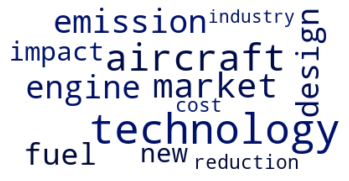

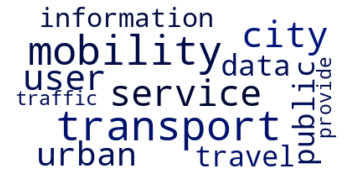

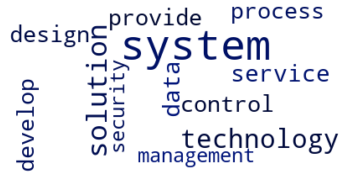

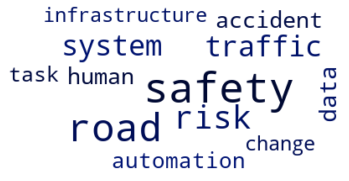

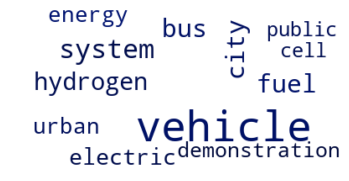

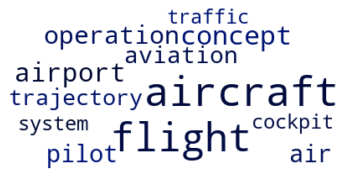

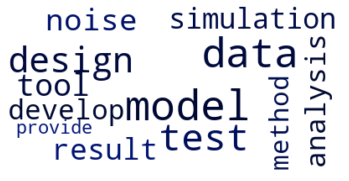

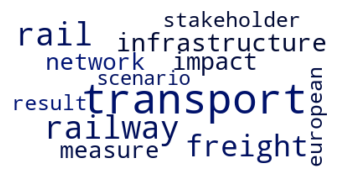

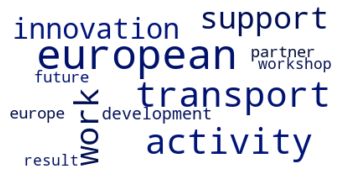

In [231]:
# generate a word cloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#text = df_mob.text[1178]
#text = {'air':1.2, 'project':1.1, 'transport': 1.05, 'security': 0.8, 'technology':0.6}

# generate a word cloud for each topic (20 words)
for key in weights:
    text = weights[key]
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=12, background_color="white").generate_from_frequencies(text)
    wordcloud.recolor(color_func = grey_color_func)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Sample 100 projects for human validation

In [156]:
rand_vec = np.sort(np.random.choice(df_final_selection.shape[0], size = 100, replace = False))

len(rand_vec)

100

In [157]:
rand_vec

array([  4,  13,  22,  50,  61,  64,  65,  66,  67,  83,  96, 114, 124,
       130, 138, 153, 161, 162, 165, 195, 201, 207, 220, 221, 225, 235,
       238, 254, 263, 266, 267, 270, 271, 278, 318, 328, 329, 330, 362,
       371, 381, 418, 425, 432, 438, 448, 466, 476, 479, 483, 495, 500,
       503, 510, 536, 545, 549, 567, 575, 584, 591, 600, 604, 606, 623,
       630, 634, 638, 641, 642, 677, 685, 690, 691, 703, 707, 714, 720,
       730, 732, 733, 737, 739, 745, 752, 768, 782, 789, 793, 800, 808,
       828, 839, 853, 859, 860, 872, 889, 912, 917])

In [158]:
# sample of 100 for validation
validation_sample = df_final_selection.iloc[rand_vec,:]

In [159]:
validation_sample.head()

,index,id,acronym,title,objective,summary,workPerformed,finalResults,text,clean_text,...,tokens,t0,t1,t2,t3,t4,t5,t6,t7,t8
4,4,213233,WISETRIP,Wide Scale network of E-systems for Multimodal...,"Mobility and demand trends of tourism, travel ...",Executive summary\n\n WISETRIP stands for 'Wid...,NaN,NaN,Wide Scale network of E-systems for Multimodal...,wide scale network multimodal journey planning...,...,"[wide, scale, network, multimodal, journey, pl...",0.000100,0.510500,0.268356,0.001812,0.006877,0.004535,0.145198,0.002415,0.060208
14,14,218504,NICHES+,New and Innovative Concepts for Helping Europe...,NICHES\ aims to network actors engaged in deve...,Executive Summary:\n1.1\tExecutive summary\nTh...,NaN,NaN,New and Innovative Concepts for Helping Europe...,new innovative concepts helping european trans...,...,"[new, innovative, concepts, helping, european,...",0.000069,0.270656,0.002173,0.000018,0.097108,0.000029,0.005395,0.402178,0.222374
25,25,233672,ICOA.10.09,"International Conference on Airports, October ...",Concept: The Air and Space Academy (AAE) propo...,Concept\n\n2-day international conference on '...,NaN,NaN,"International Conference on Airports, October ...",international conference airports october pari...,...,"[international, conference, airports, october,...",0.001044,0.043346,0.129029,0.000228,0.057884,0.171351,0.000770,0.182371,0.413976
54,54,246969,OPTION,Optimizing Policies for Transport: accounting ...,Traditional models of transport networks ignor...,The study developed new approaches to explicit...,NaN,NaN,Optimizing Policies for Transport: accounting ...,optimizing policies transport accounting indus...,...,"[optimizing, policies, transport, accounting, ...",0.111796,0.158004,0.012753,0.077702,0.084589,0.000565,0.209951,0.206129,0.138510
66,66,260087,P-MOB,Integrated Enabling Technologies for Efficient...,The P-MOB project is aiming at breaking the li...,NaN,NaN,NaN,Integrated Enabling Technologies for Efficient...,integrated enabling technologies efficient ele...,...,"[integrated, enabling, technologies, efficient...",0.324242,0.203883,0.048075,0.059175,0.358776,0.001163,0.002328,0.000725,0.001632


In [160]:
# save validation sample to csv and excel
#validation_sample.drop(['text', 'clean_text', 'score'], axis=1).to_csv("mr2_results/mr2_final_project_selection_validation_sample.csv", index=False)
#validation_sample.drop(['text', 'clean_text', 'score'], axis=1).to_excel("mr2_results/mr2_final_project_selection_validation_sample.xlsx", index=False)

# Run clustering again, but just over projects with dominant cloud 6 (5 in code!)

In [161]:
cloud_of_interest = 5 # that is cloud 6 on viz

In [162]:
cloud_interest_projects = df_dominant_topic[df_dominant_topic.Dominant_Topic == cloud_of_interest]
cloud_interest_projects.shape # this should be 114 projects

(114, 6)

In [163]:
ids_of_interest = list(cloud_interest_projects.Document_No)

In [164]:
#df_final_selection.tail()

In [165]:
#cloud_interest_projects.head()

In [166]:
cloud_interest_projects = cloud_interest_projects.merge(df_final_selection[['tokens', 'title']], how='inner', right_on = 'title', left_on = 'Project_Title')
cloud_interest_projects.shape

(114, 8)

In [167]:
cloud_interest_projects.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Project_Title,tokens,title
0,0,5.0,0.3092,"aircraft, flight, concept, airport, operation,...","[asset, aeronautic, study, seamless, transport...",ASSET – Aeronautic Study on Seamless Transport,"[asset, aeronautic, study, seamless, transport...",ASSET – Aeronautic Study on Seamless Transport
1,26,5.0,0.3711,"aircraft, flight, concept, airport, operation,...","[personal, plane, assessment, validation, pion...",Personal Plane: Assessment and Validation of P...,"[personal, plane, assessment, validation, pion...",Personal Plane: Assessment and Validation of P...
2,53,5.0,0.4099,"aircraft, flight, concept, airport, operation,...","[accelerating, egnos, adoption, aviation, acce...",ACCelerating EGNOS adoPTion in Aviation,"[accelerating, egnos, adoption, aviation, acce...",ACCelerating EGNOS adoPTion in Aviation
3,57,5.0,0.3300,"aircraft, flight, concept, airport, operation,...","[medusa, meteorological, decision, support, sy...","MEDUSA, a Meteorological Decision Support Syst...","[medusa, meteorological, decision, support, sy...","MEDUSA, a Meteorological Decision Support Syst..."
4,59,5.0,0.5225,"aircraft, flight, concept, airport, operation,...","[colaborative, meteorological, concept, valida...",Colaborative Meteorological Concept Validation...,"[colaborative, meteorological, concept, valida...",Colaborative Meteorological Concept Validation...


In [168]:
tokens_cloud_interest = cloud_interest_projects['tokens'].tolist()
dictionary_lda_cloud_interest = corpora.Dictionary(tokens_cloud_interest) # dictionary: mapping between terms and their integer IDs - id2word

In [169]:
# create corpus - BoW format = list of (token_id, token_count) tuples
corpus_cloud_interest = [dictionary_lda_cloud_interest.doc2bow(tok) for tok in tokens_cloud_interest]

In [170]:
alpha = 'auto' #[0.01]*n_topics # LDA hyperparameter, affects sparsity of topics
eta = [0.01]*len(dictionary_lda_cloud_interest.keys()) # LDA hyperparameter, affects sparsity of topics

In [171]:
# RUNS OPTIMISATION!!

model_list, coherence_values = compute_coherence_values(dictionary=dictionary_lda_cloud_interest, corpus=corpus_cloud_interest, \
                                                        texts=tokens_cloud_interest, \
                                                        start=2, limit=60, step=1, mallet=False)

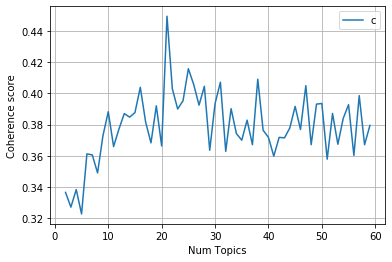

In [172]:
# Show graph
limit=60; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best'); plt.grid()
plt.show()

In [175]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3365
Num Topics = 3  has Coherence Value of 0.3271
Num Topics = 4  has Coherence Value of 0.3383
Num Topics = 5  has Coherence Value of 0.3227
Num Topics = 6  has Coherence Value of 0.3612
Num Topics = 7  has Coherence Value of 0.3606
Num Topics = 8  has Coherence Value of 0.349
Num Topics = 9  has Coherence Value of 0.3728
Num Topics = 10  has Coherence Value of 0.3883
Num Topics = 11  has Coherence Value of 0.3659
Num Topics = 12  has Coherence Value of 0.3771
Num Topics = 13  has Coherence Value of 0.3871
Num Topics = 14  has Coherence Value of 0.3848
Num Topics = 15  has Coherence Value of 0.3877
Num Topics = 16  has Coherence Value of 0.4039
Num Topics = 17  has Coherence Value of 0.3816
Num Topics = 18  has Coherence Value of 0.3683
Num Topics = 19  has Coherence Value of 0.392
Num Topics = 20  has Coherence Value of 0.3663
Num Topics = 21  has Coherence Value of 0.4495
Num Topics = 22  has Coherence Value of 0.4029
Num Topics = 23  has Co

In [176]:
# SELECT OPTIMAL MODEL

num_top_opt = 21 # optimal number of topics of cloud 6: 21


optimal_model = model_list[num_top_opt - 2]

In [177]:
vis = pyLDAvis.gensim.prepare(topic_model=optimal_model, corpus=corpus_cloud_interest, dictionary=dictionary_lda_cloud_interest, \
                              R = 20, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
# export as a standalone html

pyLDAvis.save_html(vis, 'mr2_results/lda_on_ATM_cloud' + str(num_top_opt) + 'version_' + version + '.html')

# Analyse topic clustering